In [ ]:
#Install lib yang dibutuhkan
!pip install PyMuPDF nltk --quiet

import os
import fitz  # PyMuPDF
import nltk

# Download the 'punkt_tab' data
nltk.download('punkt_tab') # Download the punkt_tab data
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

# ======================= Step 1: Ekstrak teks dari banyak PDF =========================
import re

# ======================= Step 1: Ekstrak teks dari banyak PDF (versi cleaned) =========================
def extract_text_from_pdfs(pdf_folder):
    texts = []
    filenames = []

    for filename in os.listdir(pdf_folder):
        if filename.endswith(".pdf"):
            doc = fitz.open(os.path.join(pdf_folder, filename))
            full_text = ""

            for page in doc:
                page_text = page.get_text()

                # ================== CLEANING START ==================

                # 1. Hapus teks noise yang sering muncul di AWS docs
                page_text = page_text.replace("Block Label:", "")
                page_text = page_text.replace("awswaf:", "")
                page_text = page_text.replace("© 202", "")  # hapus copyright
                page_text = re.sub(r'https?://\S+', '', page_text)  # hapus URL

                # 2. Hapus karakter aneh / simbol tidak relevan
                page_text = re.sub(r'[^a-zA-Z0-9\s.,;:\-?!()\'"/]', '', page_text)

                # 3. Normalisasi whitespace
                page_text = re.sub(r'\s+', ' ', page_text).strip()

                # 4. Filter halaman kosong atau terlalu pendek
                if len(page_text) > 50:
                    full_text += page_text + "\n"

                # ================== CLEANING END ==================

            texts.append(full_text)
            filenames.append(filename)

    return texts, filenames


# ======================= Step 2: Semantic Sentence-Based Chunking =========================
def sentence_chunking(text, max_tokens=100):
    """
    Memecah teks menjadi chunk berisi ~max_tokens kata, tanpa memotong kalimat.
    """
    sentences = sent_tokenize(text)
    chunks = []
    current_chunk = ""
    current_length = 0

    for sentence in sentences:
        sentence_length = len(sentence.split())

        # Jika panjang melebihi batas, langsung simpan chunk sebelumnya
        if current_length + sentence_length > max_tokens:
            chunks.append(current_chunk.strip())
            current_chunk = sentence
            current_length = sentence_length
        else:
            current_chunk += " " + sentence
            current_length += sentence_length

    if current_chunk:
        chunks.append(current_chunk.strip())

    return chunks

# ======================= MAIN =========================
pdf_folder = "/content/drive/MyDrive/dataset/aws"  # Pastikan folder ini sesuai lokasi PDF-mu
texts, filenames = extract_text_from_pdfs(pdf_folder)

# Proses chunking semua file PDF
all_chunks = []
for text in texts:
    chunks = sentence_chunking(text, max_tokens=100)
    all_chunks.extend(chunks)

# Tampilkan contoh hasil
print(f"Total chunk: {len(all_chunks)}")
print("\nContoh 3 chunk pertama:\n")
for i, chunk in enumerate(all_chunks[:3]):
    print(f"[{i+1}] {chunk}\n{'-'*80}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 71.3 MB/s eta 0:00:00


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Total chunk: 14828

Contoh 3 chunk pertama:

[1] User Guide AWS Artifact Copyright 5 Amazon Web Services, Inc. and/or its aliates. All rights reserved. AWS Artifact User Guide AWS Artifact: User Guide Copyright 5 Amazon Web Services, Inc. and/or its aliates. All rights reserved. Amazon's trademarks and trade dress may not be used in connection with any product or service that is not Amazon's, in any manner that is likely to cause confusion among customers, or in any manner that disparages or discredits Amazon.
--------------------------------------------------------------------------------
[2] All other trademarks not owned by Amazon are the property of their respective owners, who may or may not be aliated with, connected to, or sponsored by Amazon. AWS Artifact User Guide Table of Contents What is AWS Artifact?
--------------------------------------------------------------------------------
[3] ..........................................................................................

In [ ]:
# Install dependencies
!pip install rank_bm25 faiss-cpu sentence-transformers --quiet

from rank_bm25 import BM25Okapi
from sentence_transformers import SentenceTransformer
import numpy as np
import faiss

# ======================= 1. BM25 Indexing =========================
def build_bm25_index(chunks):
    tokenized_corpus = [chunk.lower().split() for chunk in chunks]
    bm25 = BM25Okapi(tokenized_corpus)
    return bm25, tokenized_corpus

# ======================= 2. Dense Embedding Indexing (FAISS) =========================
def build_dense_index(chunks, model):
    embeddings = model.encode(chunks)
    index = faiss.IndexFlatL2(embeddings.shape[1])
    index.add(np.array(embeddings))
    return index, embeddings

# ======================= 3. Hybrid Search =========================
def hybrid_search(query, chunks, bm25, tokenized_corpus, faiss_index, dense_model, dense_embeddings, top_k=5, alpha=0.5):
    # BM25 search
    bm25_scores = bm25.get_scores(query.lower().split())
    bm25_topk_idx = np.argsort(bm25_scores)[::-1][:top_k * 2]

    # Dense search
    query_embedding = dense_model.encode([query])
    _, dense_topk_idx = faiss_index.search(query_embedding, top_k * 2)
    dense_topk_idx = dense_topk_idx[0]

    # Fusion: Combine BM25 + Dense with weight alpha
    combined_scores = {}
    for idx in set(bm25_topk_idx).union(set(dense_topk_idx)):
        bm25_score = bm25_scores[idx]
        dense_score = 1 - np.linalg.norm(dense_embeddings[idx] - query_embedding[0])  # similarity
        combined_scores[idx] = alpha * bm25_score + (1 - alpha) * dense_score

    # Ambil top-k hasil
    final_topk = sorted(combined_scores.items(), key=lambda x: x[1], reverse=True)[:top_k]
    return [chunks[idx] for idx, _ in final_topk]

# ======================= MAIN =========================
# Pastikan kamu sudah punya 'all_chunks' dari langkah sebelumnya
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

# Build both index
bm25_index, tokenized = build_bm25_index(all_chunks)
faiss_index, dense_embeds = build_dense_index(all_chunks, embedding_model)

# Contoh query
query = "What is AWS Artifact?"
top_chunks = hybrid_search(query, all_chunks, bm25_index, tokenized, faiss_index, embedding_model, dense_embeds)

# Tampilkan hasil retrieval
print("Top hasil retrieval hybrid:")
for i, chunk in enumerate(top_chunks):
    print(f"\n[{i+1}] {chunk[:300]}...\n{'-'*80}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.3 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Top hasil retrieval hybrid:

[1] All other trademarks not owned by Amazon are the property of their respective owners, who may or may not be aliated with, connected to, or sponsored by Amazon. AWS Artifact User Guide Table of Contents What is AWS Artifact?...
--------------------------------------------------------------------------------

[2] In contrast, AWS Audit Manager helps you collect, review, and manage evidence to demonstrate that your usage of AWS services is in compliance. For more information about AWS Artifact, see What is AWS Artifact? in the AWS Artifact User Guide. You can download a list of AWS reports in the AWS Manageme...
--------------------------------------------------------------------------------

[3] AWS Firewall Manager provides management of protections like AWS WAF and Shield Advanced across accounts and resources, even as new resources are added. Topics What is AWS WAF? What is AWS Shield Advanced? What is AWS Firewall Manager? What is AWS WAF? AWS WAF is 

In [ ]:
# Install Huggingface Transformers
!pip install transformers --quiet

from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch

# ======================= Setup Model & Tokenizer =========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
t5_model = T5ForConditionalGeneration.from_pretrained("t5-small").to(device)
t5_tokenizer = T5Tokenizer.from_pretrained("t5-small")

# ======================= Generator Function =========================
def generate_answer(query, retrieved_chunks, model, tokenizer, max_input_length=512, max_output_length=128):
    # Gabungkan context + query
    context_text = "\n".join(retrieved_chunks)
    input_text = f"Question: {query}\nContext: {context_text}"

    # Tokenisasi input
    input_ids = tokenizer.encode(input_text, return_tensors="pt", max_length=max_input_length, truncation=True).to(device)

    # Generate output
    output_ids = model.generate(input_ids, max_length=max_output_length, num_beams=4, early_stopping=True)
    answer = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return answer


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [ ]:
# Ambil top-k chunks dari Hybrid Retrieval sebelumnya
query = "What is AWS Audit Manager?"
retrieved_chunks = hybrid_search(query, all_chunks, bm25_index, tokenized, faiss_index, embedding_model, dense_embeds)

# Generate jawaban
generated = generate_answer(query, retrieved_chunks, t5_model, t5_tokenizer)
print("✨ Jawaban Generator:\n")
print(generated)


✨ Jawaban Generator:

AWS Audit Manager User Guide You're familiar with AWS Audit Manager terminology and functionality. For more information, see Setting up AWS Audit Manager with the recommended settings.


In [ ]:
!pip install rouge-score bert-score --quiet


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.1 MB/s eta 0:00:00


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


,Query,Generated Answer,Reference Answer,ROUGE-L Score,BERTScore (F1)
0,What is GuardDuty?,Amazon GuardDuty Amazon GuardDuty User Guide T...,GuardDuty is an intelligent threat detection s...,0.082474,0.812282
1,What are the key benefits of GuardDuty?,AWS KMS key AWS KMS key AWS KMS key includes m...,GuardDuty makes it easier to continuously moni...,0.112500,0.825226
2,What is Amazon Cognito?,Amazon Cognito Developer Guide Table of Conten...,"Amazon Cognito lets you add user sign-up, sign...",0.132075,0.813727
3,What is Amazon Detective?,Amazon Detective User Guide Table of Contents ...,"Amazon Detective makes it easier to analyze, i...",0.166667,0.841842
4,What is AWS Firewall Manager?,AWS Firewall Manager simplifiees administratio...,AWS Firewall Manager is a security management ...,0.268657,0.881467


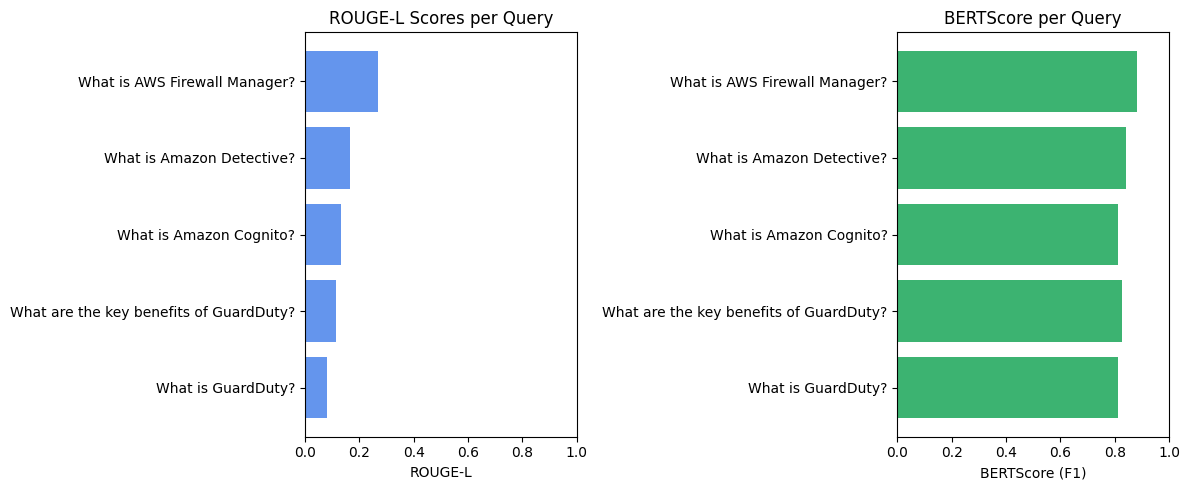

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from rouge_score import rouge_scorer
from bert_score import score as bert_score

# INPUT: Queries dan Reference Answers
queries = [
    "What is GuardDuty?",
    "What are the key benefits of GuardDuty?",
    "What is Amazon Cognito?",
    "What is Amazon Detective?",
    "What is AWS Firewall Manager?"
]

reference_answers = [
    "GuardDuty is an intelligent threat detection service that continuously monitors your AWS accounts, workloads, runtime activity, and data for malicious activity. If potential malicious activity, such as anomalous behavior, credential exfiltration, or command and control infrastructure (C2) communication is detected, GuardDuty generates detailed security findings that can be used for security visibility and assisting in remediation.",
    "GuardDuty makes it easier to continuously monitor your AWS accounts, workloads, and runtime activity. GuardDuty is designed to operate completely independently from your resources and have no performance or availability impact to your workloads. The service is fully managed with integrated threat intelligence, machine learning (ML) anomaly detection, and malware scanning. GuardDuty delivers detailed and actionable alerts that are designed to be integrated with existing event management and workflow systems. There are no upfront costs and you pay only for the events analyzed, with no additional software to deploy or threat intelligence feed subscriptions required.",
    "Amazon Cognito lets you add user sign-up, sign-in, access control, and brokered AWS service access to your web and mobile applications within minutes. It is a developer- centric, cost-effective service that provides secure, tenant-based identity stores and federation options that can scale to millions of users. Amazon Cognito helps you create branded customer experiences, improve security, and adapt to your customers’ needs.",
    "Amazon Detective makes it easier to analyze, investigate, and quickly identify the root cause of potential security issues or suspicious activities. Amazon Detective automatically collects log data from your AWS resources and uses machine learning, statistical analysis, and graph theory to build a linked set of data that enables you to easily conduct faster and more efficient security investigations.",
    "AWS Firewall Manager is a security management service which allows you to centrally configure and manage firewall rules across your accounts and applications in AWS Organization."
]

# GENERATE ANSWERS dari RAG
generated_answers = []
for query in queries:
    # Pass the necessary arguments to hybrid_search
    retrieved_chunks = hybrid_search(query, all_chunks, bm25_index, tokenized, faiss_index, embedding_model, dense_embeds)
    answer = generate_answer(query, retrieved_chunks, t5_model, t5_tokenizer) # Pass model and tokenizer to generate_answer
    generated_answers.append(answer)

# Evaluasi: ROUGE-L
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
rouge_scores = [
    scorer.score(ref, pred)['rougeL'].fmeasure
    for ref, pred in zip(reference_answers, generated_answers)
]

# Evaluasi: BERTScore
P, R, F1 = bert_score(generated_answers, reference_answers, lang='en', verbose=False)
bert_f1_scores = F1.numpy()

# Tabel Evaluasi
eval_df = pd.DataFrame({
    "Query": queries,
    "Generated Answer": generated_answers,
    "Reference Answer": reference_answers,
    "ROUGE-L Score": rouge_scores,
    "BERTScore (F1)": bert_f1_scores
})

# Tampilkan Tabel Evaluasi
from IPython.display import display
display(eval_df)

# Visualisasi
plt.figure(figsize=(12, 5))

# ROUGE-L Bar Chart
plt.subplot(1, 2, 1)
plt.barh(eval_df["Query"], eval_df["ROUGE-L Score"], color='cornflowerblue')
plt.xlabel("ROUGE-L")
plt.title("ROUGE-L Scores per Query")
plt.xlim(0, 1)

# BERTScore Bar Chart
plt.subplot(1, 2, 2)
plt.barh(eval_df["Query"], eval_df["BERTScore (F1)"], color='mediumseagreen')
plt.xlabel("BERTScore (F1)")
plt.title("BERTScore per Query")
plt.xlim(0, 1)

plt.tight_layout()
plt.show()

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


,Query,Generated Answer,Reference Answer,ROUGE-L Score,BERTScore (F1)
0,What is GuardDuty?,Amazon GuardDuty Amazon GuardDuty User Guide T...,GuardDuty is an intelligent threat detection s...,0.064516,0.820006
1,What are the key benefits of GuardDuty?,AWS KMS key AWS KMS key AWS KMS key includes m...,GuardDuty makes it easier to continuously moni...,0.080808,0.835121
2,What is Amazon Cognito?,Amazon Cognito Developer Guide Table of Conten...,"Amazon Cognito lets you add user sign-up, sign...",0.092308,0.818909
3,What is Amazon Detective?,Amazon Detective User Guide Table of Contents ...,"Amazon Detective makes it easier to analyze, i...",0.148936,0.845659
4,What is AWS Firewall Manager?,AWS Firewall Manager simplifiees administratio...,AWS Firewall Manager is a security management ...,0.268657,0.881467


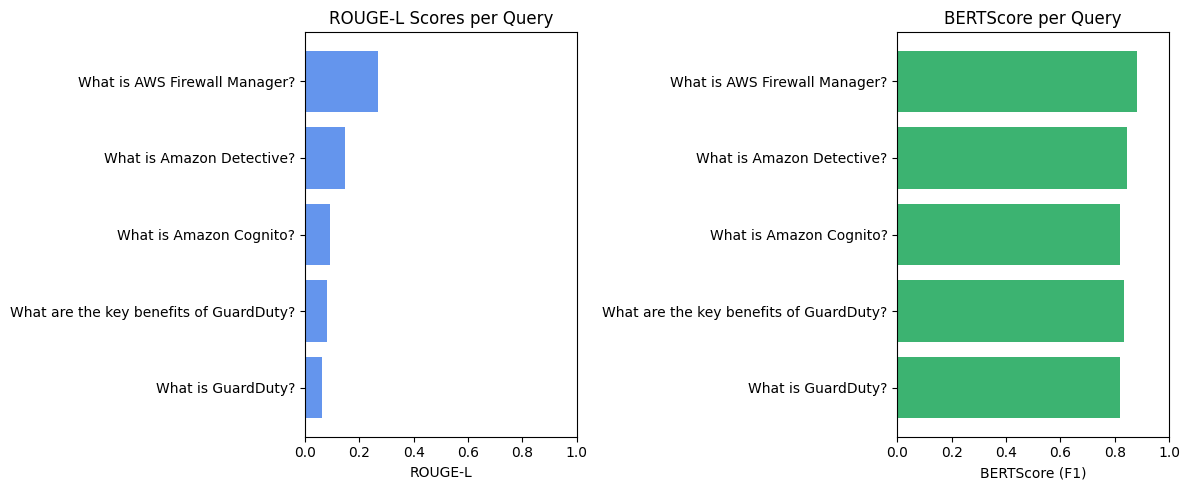

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from rouge_score import rouge_scorer
from bert_score import score as bert_score

# ---------------------------
# INPUT: Queries and Reference Answers
# ---------------------------
queries = [
    "What is GuardDuty?",
    "What are the key benefits of GuardDuty?",
    "What is Amazon Cognito?",
    "What is Amazon Detective?",
    "What is AWS Firewall Manager?"
]

reference_answers = [
    "GuardDuty is an intelligent threat detection service that continuously monitors your AWS accounts, workloads, runtime activity, and data for malicious activity.",
    "GuardDuty makes it easier to continuously monitor your AWS accounts, workloads, and runtime activity. GuardDuty is designed to operate completely independently from your resources and have no performance or availability impact to your workloads.",
    "Amazon Cognito lets you add user sign-up, sign-in, access control, and brokered AWS service access to your web and mobile applications within minutes.",
    "Amazon Detective makes it easier to analyze, investigate, and quickly identify the root cause of potential security issues or suspicious activities.",
    "AWS Firewall Manager is a security management service which allows you to centrally configure and manage firewall rules across your accounts and applications in AWS Organization."
]

# ---------------------------
# GENERATE ANSWERS FROM RAG
# ---------------------------
generated_answers = []
for query in queries:
    # Pass the necessary arguments to hybrid_search
    retrieved_chunks = hybrid_search(query, all_chunks, bm25_index, tokenized, faiss_index, embedding_model, dense_embeds)
    answer = generate_answer(query, retrieved_chunks, t5_model, t5_tokenizer) # Pass model and tokenizer to generate_answer
    generated_answers.append(answer)

# ---------------------------
# EVALUATION: ROUGE-L
# ---------------------------
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
rouge_scores = [
    scorer.score(ref, pred)['rougeL'].fmeasure
    for ref, pred in zip(reference_answers, generated_answers)
]

# ---------------------------
# EVALUATION: BERTScore
# ---------------------------
P, R, F1 = bert_score(generated_answers, reference_answers, lang='en', verbose=False)
bert_f1_scores = F1.numpy()

# ---------------------------
# BUILD EVALUATION TABLE
# ---------------------------
eval_df = pd.DataFrame({
    "Query": queries,
    "Generated Answer": generated_answers,
    "Reference Answer": reference_answers,
    "ROUGE-L Score": rouge_scores,
    "BERTScore (F1)": bert_f1_scores
})

# Display table
from IPython.display import display
display(eval_df)

# ---------------------------
# VISUALIZATION
# ---------------------------
plt.figure(figsize=(12, 5))

# ROUGE-L Bar Chart
plt.subplot(1, 2, 1)
plt.barh(eval_df["Query"], eval_df["ROUGE-L Score"], color='cornflowerblue')
plt.xlabel("ROUGE-L")
plt.title("ROUGE-L Scores per Query")
plt.xlim(0, 1)

# BERTScore Bar Chart
plt.subplot(1, 2, 2)
plt.barh(eval_df["Query"], eval_df["BERTScore (F1)"], color='mediumseagreen')
plt.xlabel("BERTScore (F1)")
plt.title("BERTScore per Query")
plt.xlim(0, 1)

plt.tight_layout()
plt.show()
